### Monitoring

https://docs.google.com/forms/d/e/1FAIpQLSdp5m6U0yyQMQgGNgYeM3bnLMY65sNOelxp8Ur0lOg4rVLmyw/viewform?usp=sf_link

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir
from pathlib2 import Path

In [3]:
# WHERE TO SAVE DATA
DATA_DIR = Path('/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos')
subject = 'rockwell_mouse'

### Get camera information

In [4]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)
- [Kinect SDK](https://microsoft.github.io/Azure-Kinect-Sensor-SDK/master/structk4a__device__configuration__t_a8208974f05d89fc1362c6a0900bdef4d.html#a8208974f05d89fc1362c6a0900bdef4d)

In [5]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [6]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            #"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": True,
            "save_color": True,
        },
    }
}

### Set up processing functions
- Functions for reducing video file sizes to 8 bit. 

In [7]:
_dtype = np.uint16
if _dtype == np.uint8:
    def process_depth(depth):
        return np.clip((depth - 435) * (depth < 690), 0, 255).astype(_dtype)
    def process_ir(ir):
        ir = np.clip(ir + 100, 160, 5500)
        return ((np.log(ir) - 5) * 70).astype(_dtype)
    ir_display_fcn=None
    depth_display_fcn=None
elif _dtype == np.uint16:
    def process_depth(depth):
        depth = depth.astype(_dtype)
        return depth
    def process_ir(ir):
        return ir.astype(_dtype)
    def process_ir_16(ir):
        ir = (np.clip(ir, 0, 8000)/32).astype(np.uint8)
        return ir
    
    def process_depth_display(ir):
        #ir[ir > 800] = 800
        #ir[ir < 300] = 300
        #ir -= 300
        ir = ((ir / np.max(ir))*256).astype(np.uint8)
        return ir
    ir_display_fcn = process_ir_16
    depth_display_fcn = process_depth_display#

In [8]:
display = 'depth'
if display == 'ir':
    display_fcn = ir_display_fcn
else:
    display_fcn = depth_display_fcn

### Recording parameters

In [9]:
depth_write_frames_kwargs={
        "codec": "ffv1", #"ffv1",
        "crf": 0, # The range of the CRF scale is 0–51, where 0 is lossless (for 8 bit only, for 10 bit use -qp 0), 23 is the default, and 51 is worst quality possible
        "threads": 6, # Set the number of threads to use while encoding.
        "fps": 30,
        "slices": 24, # Number of slices, used in parallelized encoding.
        "slicecrc": 1, # Enabling this option adds CRC 2information to each slice
        "frame_size": None,
        "get_cmd": False,
    }

In [10]:
ir_write_frames_kwargs={
        "codec": "h264", #"ffv1",
        "crf": 0, # The range of the CRF scale is 0–51, where 0 is lossless (for 8 bit only, for 10 bit use -qp 0), 23 is the default, and 51 is worst quality possible
        "threads": 6, # Set the number of threads to use while encoding.
        "fps": 30,
        "slices": 24, # Number of slices, used in parallelized encoding.
        "slicecrc": 1, # Enabling this option adds CRC information to each slice
        "frame_size": None,
        "get_cmd": False,
    }

In [11]:
color_write_frames_kwargs={
        "codec": "h264", #"h264",
        "crf": 22,
        "threads": 6,
        "fps": 30,
        "slices": 24,
        "slicecrc": 1,
        "frame_size": None,
        "get_cmd": False,
    }

In [12]:
recording_duration_s = 35*60*1

### Run recording

In [13]:
import datetime

In [14]:
import time

In [15]:
try:
    while True:
        # create a new timestamp
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        print(timestamp)
        filename_prefix = DATA_DIR / subject / timestamp
        ensure_dir(filename_prefix)

        # start recording
        start_recording(
            filename_prefix,
            recording_duration_s,
            devices=devices,
            depth_function = process_depth,
            ir_function = process_ir,
            ir_dtype = _dtype,
            depth_dtype = _dtype,
            ir_write_frames_kwargs=ir_write_frames_kwargs,
            depth_write_frames_kwargs=depth_write_frames_kwargs,
            color_write_frames_kwargs=color_write_frames_kwargs,
            display_fcn=display_fcn,
            display = display,
        )
        
        # wait until the previous file is finished writing
        for device in devices:
            while True:
                is_writing = np.load(filename_prefix / device / 'is_writing.npy')[0]
                if is_writing == False:
                    break
                time.sleep(1)
        ### DELETE ME ###
        break
        
except KeyboardInterrupt:
    print('KeyboardInterrupt: notebook loop')

2022-09-29_17-21-33


master (frames written):   0%|          | 0/63000 [00:00<?, ?it/s]

Recording (s):   0%|          | 0/2100 [00:00<?, ?it/s]

capture_from_azure initialized: master 
 

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to target thread (0x556da43cdf90)

QObject::moveToThread: Current thread (0x556da43cdf90) is not the object's thread (0x556da486e570).
Cannot move to tar

 Recording stopped early
Exiting: KeyboardInterrupt
Framerate (master):29.9891
Pipe broken for depth_repipe
  continuing on to depth_repipe_repipe
Pipe broken for ir_repipe
  continuing on to ir_repipe_repipe
Pipe broken for color_repipe
  continuing on to color_repipe_repipe
Finished writing (master): 2022-09-29 17:54:05.572113


### Read and show file

In [16]:
print('\n'.join([i.as_posix() for i in list((filename_prefix/'master').iterdir())]))

/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/ir.avi
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/color_repipe.avi
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/ir_repipe.avi
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/color_timestamps.npy
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/depth_repipe.avi
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/ir_timestamps.npy
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/depth_timestamps.npy
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/system_timestamps.npy
/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-

In [17]:
#filename_prefix = Path('/home/dattalab/Downloads/Examples/22_3_3_chr/2022-09-23_11-47-21')

In [18]:
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

In [19]:
len(system_timestamps)

58429

In [20]:
len(system_timestamps) /((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

29.989112684237092

In [21]:
((np.max(system_timestamps) - np.min(system_timestamps))*1e-9)

1948.340406574

In [22]:
depth_timestamps = np.load(filename_prefix / 'master' / 'depth_timestamps.npy')
system_timestamps = np.load(filename_prefix / 'master' / 'system_timestamps.npy')

In [23]:
#plt.plot((system_timestamps[0] - system_timestamps)- depth_timestamps);

In [24]:
from kinectacq.video_io import read_frames

In [25]:
file_loc = filename_prefix / 'master' /  "ir.avi"
frames = read_frames(
    file_loc,
    [0,1,2],
    threads=6,
    fps=30,
    pixel_format="gray16",
    frame_size=(640, 576),
    slices=24,
    slicecrc=1,
    get_cmd=False,
)

In [26]:
file_loc

PosixPath('/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/ir.avi')

In [27]:
vidcap = cv2.VideoCapture(file_loc.as_posix())
total_frames = vidcap.get(7)

In [28]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 41077 MB
actual_size: 3339 MB
size per hour: 5.7 GB


(array([7.2497e+04, 1.6680e+03, 4.4000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9100e+02]),
 array([1.0000e+00, 6.5540e+03, 1.3107e+04, 1.9660e+04, 2.6213e+04,
        3.2766e+04, 3.9319e+04, 4.5872e+04, 5.2425e+04, 5.8978e+04,
        6.5531e+04]),
 <BarContainer object of 10 artists>)

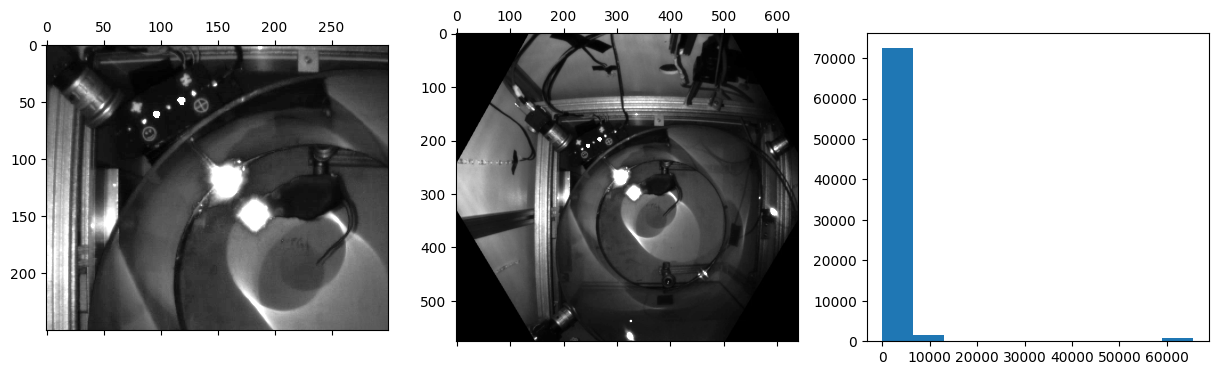

In [29]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
frame = frames[0].astype(np.float32)
axs[1].matshow(frame, cmap='Greys_r', vmin = 0, vmax=8000, interpolation=None)

frame = frames[0][150:400, 150:450]
axs[0].matshow(frame, cmap='Greys_r', vmin = 0, vmax=8000, interpolation=None)
axs[2].hist(frame.flatten())

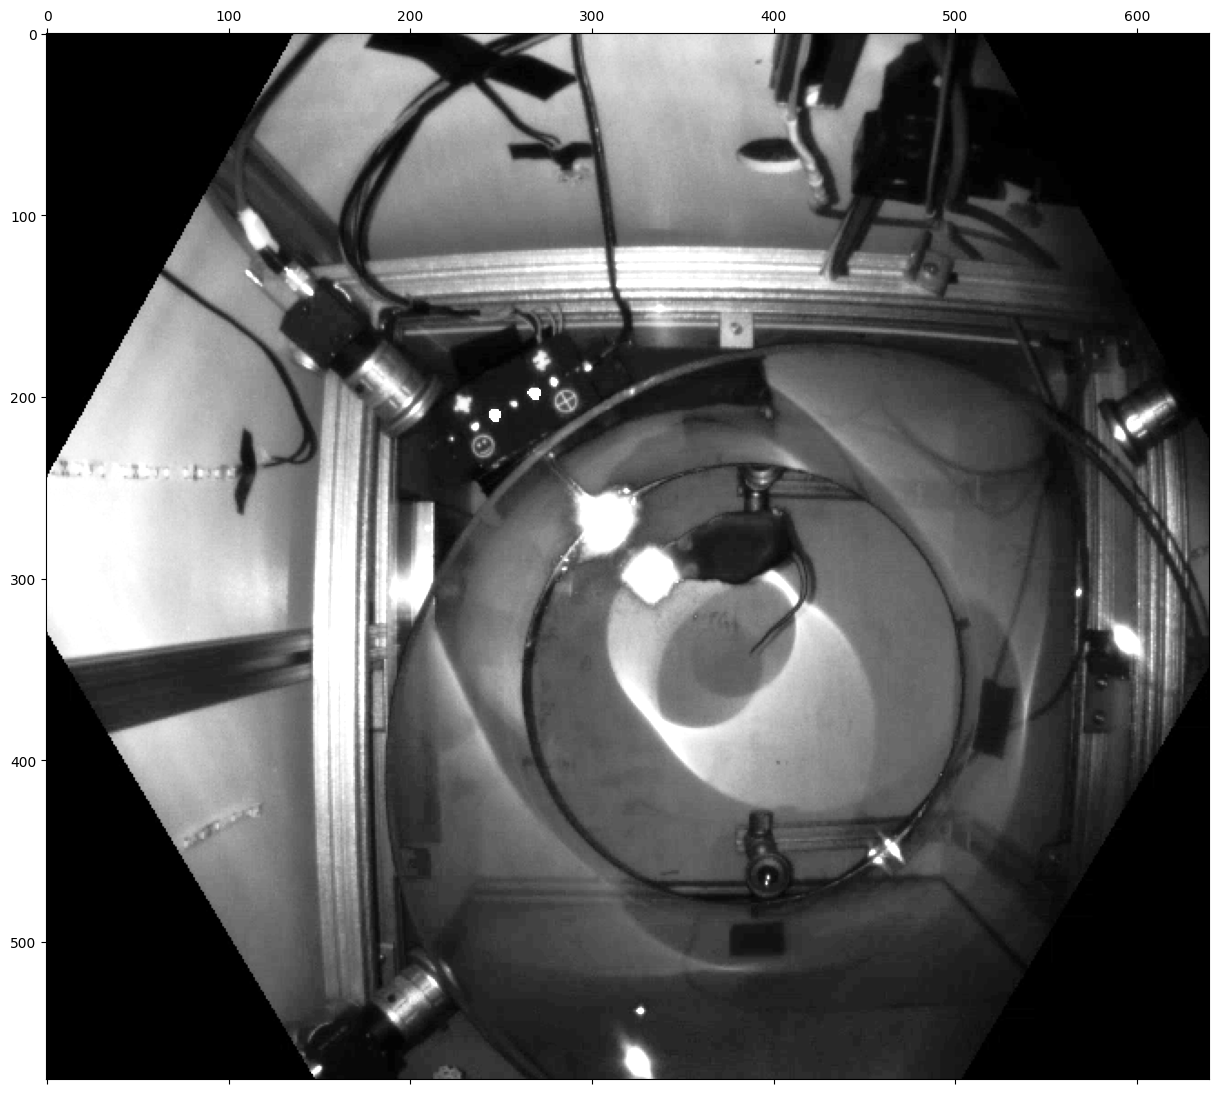

In [30]:
fig, axs = plt.subplots(ncols=1, figsize=(15,15))
frame = frames[0].astype(np.float32)
axs.matshow(frame, cmap='Greys_r', vmin = 0, vmax=5000, interpolation=None)


### Depth data

In [31]:
filename_prefix / 'master' /  "depth.avi"

PosixPath('/home/dattalab/JARVIS/sync_flir_azure_9_27/azure_videos/rockwell_mouse/2022-09-29_17-21-33/master/depth.avi')

In [65]:
file_loc = filename_prefix / 'master' /  "depth.avi"
frames = read_frames(
    file_loc,
    np.arange(100),
    threads=6,
    fps=30,
    pixel_format="gray16",
    frame_size=(640, 576),
    slices=24,
    slicecrc=1,
    get_cmd=False,
)
vidcap = cv2.VideoCapture(file_loc.as_posix())
total_frames = vidcap.get(7)

In [66]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 41077 MB
actual_size: 3555 MB
size per hour: 6.1 GB


In [69]:
frame = 99

(array([1.57752e+05, 0.00000e+00, 0.00000e+00, 3.89000e+02, 5.06000e+03,
        2.27010e+04, 2.60340e+04, 4.81900e+04, 1.83250e+04, 1.36200e+04,
        7.95700e+03, 1.20000e+01, 1.66000e+02, 4.24000e+02, 6.80000e+02,
        4.76600e+03, 5.06120e+04, 1.19400e+04, 0.00000e+00, 1.20000e+01]),
 array([   0.        ,   61.20000076,  122.40000153,  183.6000061 ,
         244.80000305,  306.        ,  367.20001221,  428.3999939 ,
         489.6000061 ,  550.79998779,  612.        ,  673.20001221,
         734.40002441,  795.59997559,  856.79998779,  918.        ,
         979.20001221, 1040.40002441, 1101.59997559, 1162.80004883,
        1224.        ]),
 <BarContainer object of 20 artists>)

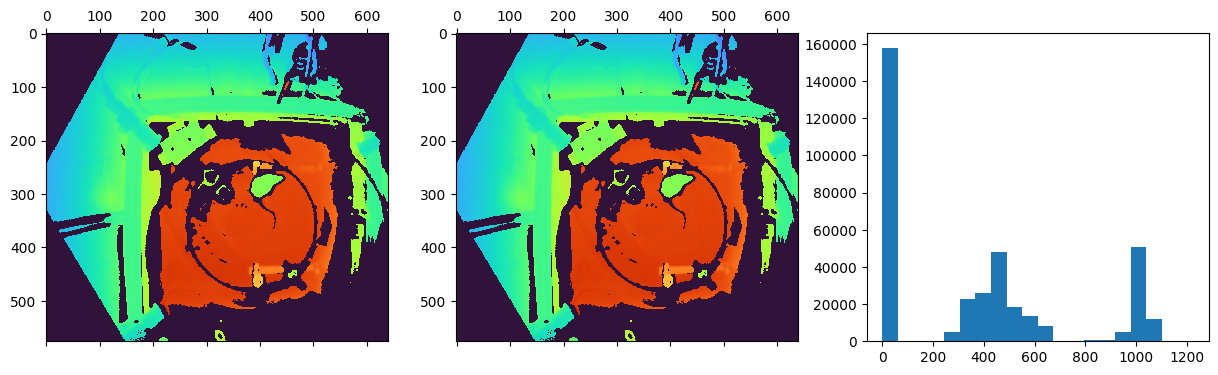

In [70]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
frame = frames[frame].astype(np.float32)
axs[1].matshow(frame, cmap='turbo')#, vmin = 200, vmax=800)

#frame = frames[2][150:400, 150:450]
axs[0].matshow(frame, cmap='turbo')#, vmin = 200, vmax=800)
axs[2].hist(frame.flatten(), bins=20)

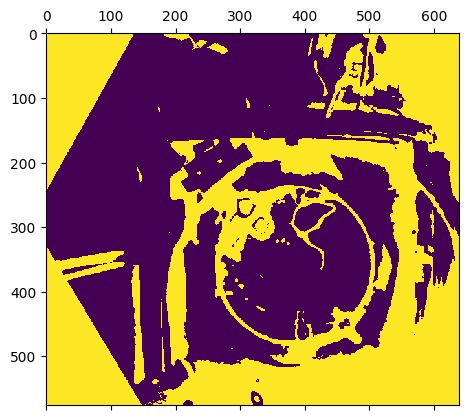

In [71]:
plt.matshow(frame == 0)

In [53]:
import matplotlib

In [38]:
frame.shape

(250, 300)

In [39]:
matplotlib.cm.jet(frame).shape

(250, 300, 4)

(array([2.4129e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.5200e+02, 2.3360e+03, 5.7500e+03, 7.6730e+03,
        6.3470e+03, 6.1000e+02, 9.4000e+01, 6.3000e+01, 2.5100e+02,
        9.0000e+00, 6.2400e+03, 2.0536e+04, 0.0000e+00, 1.0000e+01]),
 array([   0. ,   59.8,  119.6,  179.4,  239.2,  299. ,  358.8,  418.6,
         478.4,  538.2,  598. ,  657.8,  717.6,  777.4,  837.2,  897. ,
         956.8, 1016.6, 1076.4, 1136.2, 1196. ]),
 <BarContainer object of 20 artists>)

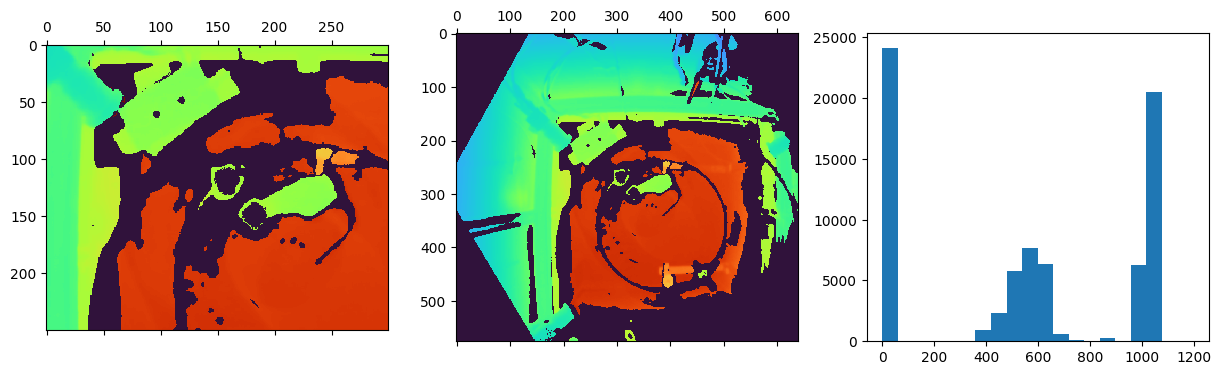

In [40]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
frame = frames[2].astype(np.float32)
axs[1].matshow(frame, cmap='turbo')#, vmin = 500, vmax=650)

frame = frames[2][150:400, 150:450]
axs[0].matshow(frame, cmap='turbo')#, vmin = 500, vmax=650)
axs[2].hist(frame.flatten(), bins=20)

### color data

In [41]:
file_loc = filename_prefix / 'master' /  "color.avi"
vidcap = cv2.VideoCapture(file_loc.as_posix())
success,image = vidcap.read()
total_frames = vidcap.get(7)
print(total_frames, image.shape)

58425.0 (720, 1280, 3)


In [42]:
nbit = 16
total_expected_bits = total_frames * np.product(frames[0].shape) * nbit
total_expected_MB_uncompressed = total_expected_bits * 1.192e-7 
GB_per_hour = os.path.getsize(file_loc) / (recording_duration_s / (60*60)) * 1e-9
print('uncompressed size: {} MB'.format(round(total_expected_MB_uncompressed)))
print('actual_size: {} MB'.format(round(os.path.getsize(file_loc) * 1e-6)))
print('size per hour: {} GB'.format(round(GB_per_hour, 1)))

uncompressed size: 41077 MB
actual_size: 207 MB
size per hour: 0.4 GB


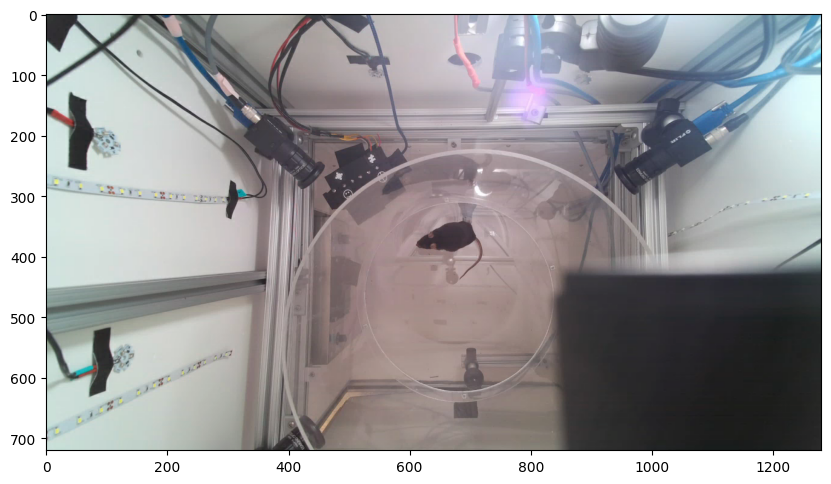

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

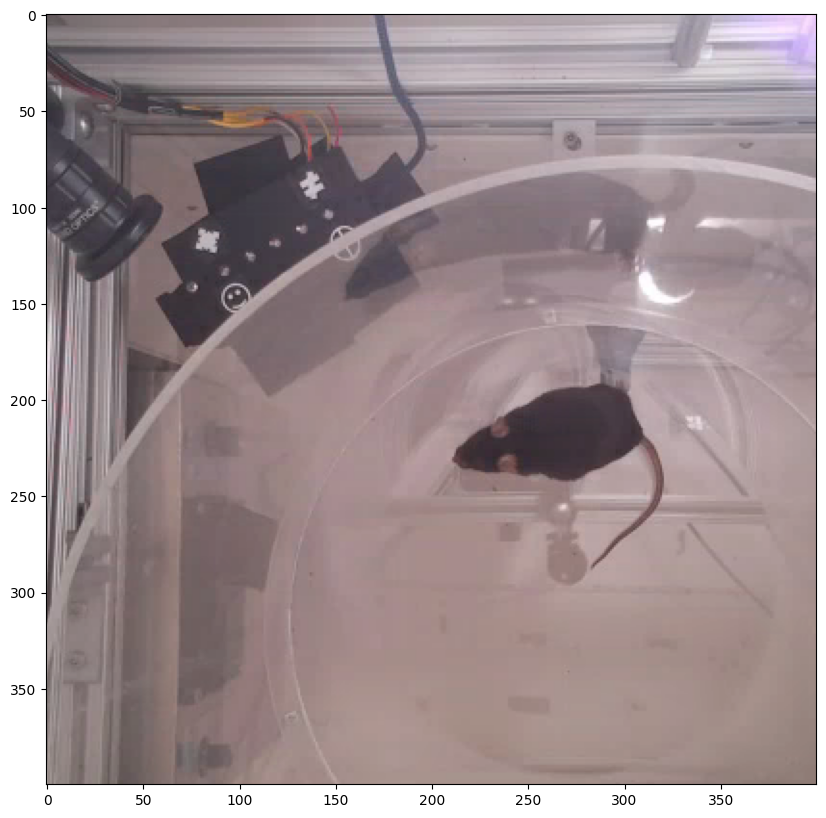

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image[150:550, 400:800])